# Notebook for the audio feature of the dualsenseo controller.

## 1 Mic limitation

by using the externel device play the audio from 20hz to 22000hz, then plot the frequency of the mic detection

In [82]:
import numpy as np
import pyaudio
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

def list_microphones():
    pa = pyaudio.PyAudio()
    print("Available Microphone Devices:\n")
    
    for i in range(pa.get_device_count()):
        device_info = pa.get_device_info_by_index(i)
        if device_info['maxInputChannels'] > 0:
            print(f"Device Index: {i}")
            print(f"  Name: {device_info['name']}")
            print(f"  Channels: {device_info['maxInputChannels']}")
            print(f"  Default Sample Rate: {device_info['defaultSampleRate']}")
            print(f"  Is Default Input Device: {'Yes' if i == pa.get_default_input_device_info()['index'] else 'No'}")
            print("-" * 30)
    
    pa.terminate()

def get_device_channels(device_index):
    pa = pyaudio.PyAudio()
    device_info = pa.get_device_info_by_index(device_index)
    pa.terminate()
    return device_info['maxInputChannels']

def capture_and_visualize(device_index=0, duration=10):
    # Get the actual number of channels for the device
    channels = 1
    
    # Parameters
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    RATE = 44100
    
    # Initialize PyAudio
    pa = pyaudio.PyAudio()
    
    try:
        # Open the selected audio input stream
        stream = pa.open(format=FORMAT,
                        channels=channels,
                        rate=RATE,
                        input=True,
                        input_device_index=device_index,
                        frames_per_buffer=CHUNK)
        
        print(f"Recording for {duration} seconds from device index {device_index} with {channels} channels...")
        
        # Collect audio data
        frames = []
        for _ in range(0, int(RATE / CHUNK * duration)):
            try:
                data = stream.read(CHUNK)
                frames.append(np.frombuffer(data, dtype=np.int16))
            except Exception as e:
                print(f"Error reading stream: {e}")
                break
        
        # Close the stream
        stream.stop_stream()
        stream.close()
        
        # Combine frames into a single numpy array
        audio_data = np.concatenate(frames)
        
        # Reshape based on number of channels
        if channels > 1:
            audio_data = audio_data.reshape(-1, channels)
            print(f"Audio input has {channels} channels. Analyzing channel 1 only.")
            channel_data = audio_data[:, 0]
        else:
            channel_data = audio_data
        
        # Time domain visualization
        plt.figure(figsize=(14, 8))
        plt.subplot(3, 1, 1)
        time_axis = np.linspace(0, len(channel_data) / RATE, num=len(channel_data))
        plt.plot(time_axis, channel_data, color='blue')
        plt.title("Sound Wave (Channel 1)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        
        # Frequency domain visualization
        fft_data = fft(channel_data)
        fft_magnitude = np.abs(fft_data)[:len(fft_data)//2]
        freqs = fftfreq(len(channel_data), 1 / RATE)[:len(fft_data)//2]
        
        plt.subplot(3, 1, 2)
        plt.plot(freqs, fft_magnitude, color='red')
        plt.title("Frequency Spectrum (FFT - Channel 1)")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        
        # Calculate average frequency
        avg_frequency = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude)
        print(f"Average Frequency (Channel 1): {avg_frequency:.2f} Hz")
        
        # Dominant frequency visualization
        dominant_freq = freqs[np.argmax(fft_magnitude)]
        plt.subplot(3, 1, 3)
        plt.plot(freqs, fft_magnitude, color='green')
        plt.axvline(x=dominant_freq, color='red', linestyle='--')
        plt.title("Dominant Frequency (Channel 1)")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.text(dominant_freq, max(fft_magnitude), f'{dominant_freq:.2f} Hz', color='red')
        
        plt.tight_layout()
        plt.show()
        
        return avg_frequency, dominant_freq
    
    finally:
        pa.terminate()

In [77]:
list_microphones()

Available Microphone Devices:

Device Index: 1
  Name: DualSense Wireless Controller
  Channels: 2
  Default Sample Rate: 48000.0
  Is Default Input Device: No
------------------------------
Device Index: 2
  Name: MacBook Air Microphone
  Channels: 1
  Default Sample Rate: 48000.0
  Is Default Input Device: Yes
------------------------------
Device Index: 4
  Name: Wayne iPhone Microphone
  Channels: 1
  Default Sample Rate: 48000.0
  Is Default Input Device: No
------------------------------


#### 1.1 Image 1 macos default mic

Recording for 20 seconds from device index 2 with 1 channels...
Average Frequency (Channel 1): 5041.79 Hz


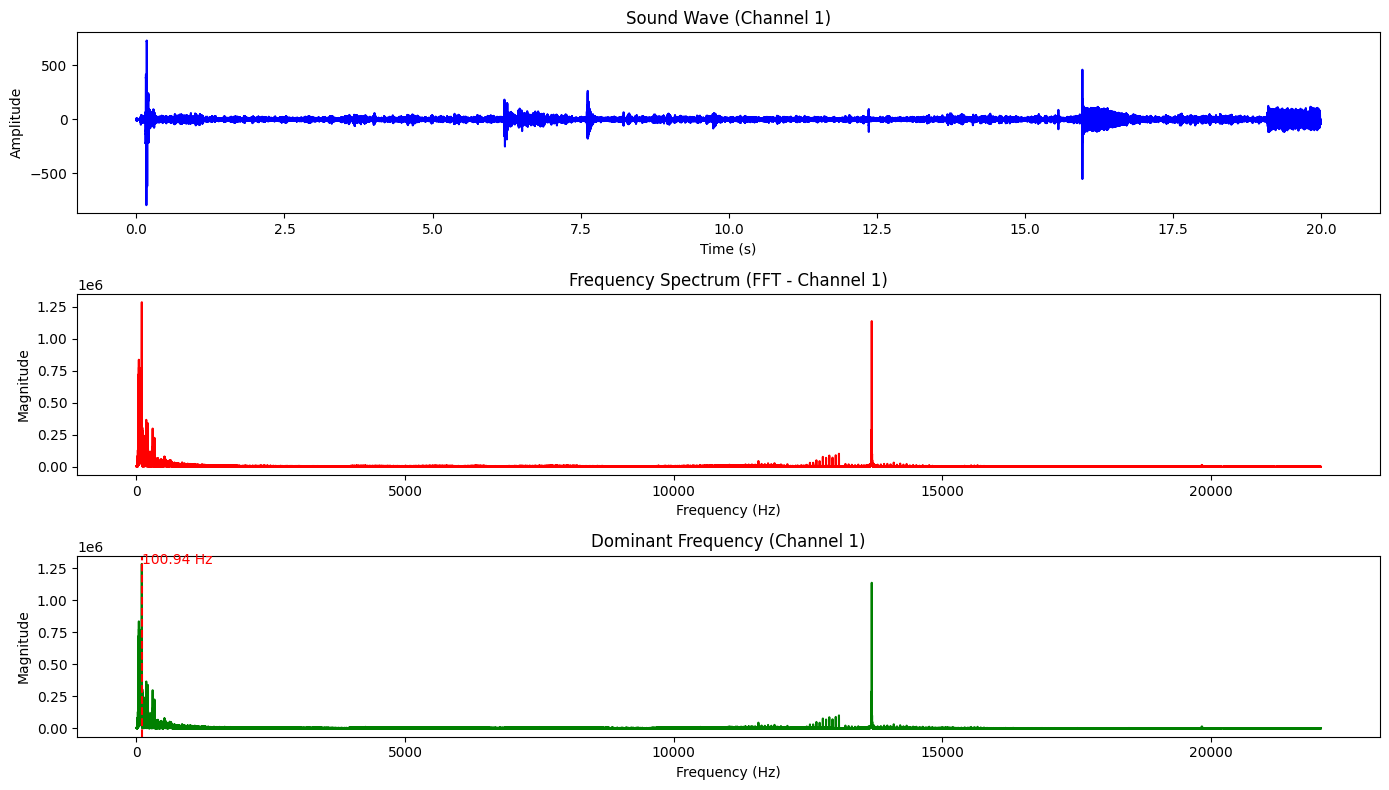

(np.float64(5041.785362804034), np.float64(100.93845274390243))

In [84]:
# play 19000hz 5s on the devcie of the macbook air m3 device 
capture_and_visualize(device_index=2, duration=20)


#### 1.2 Controller mic upper bound 

Recording for 5 seconds from device index 1 with 1 channels...
Average Frequency (Channel 1): 5679.52 Hz


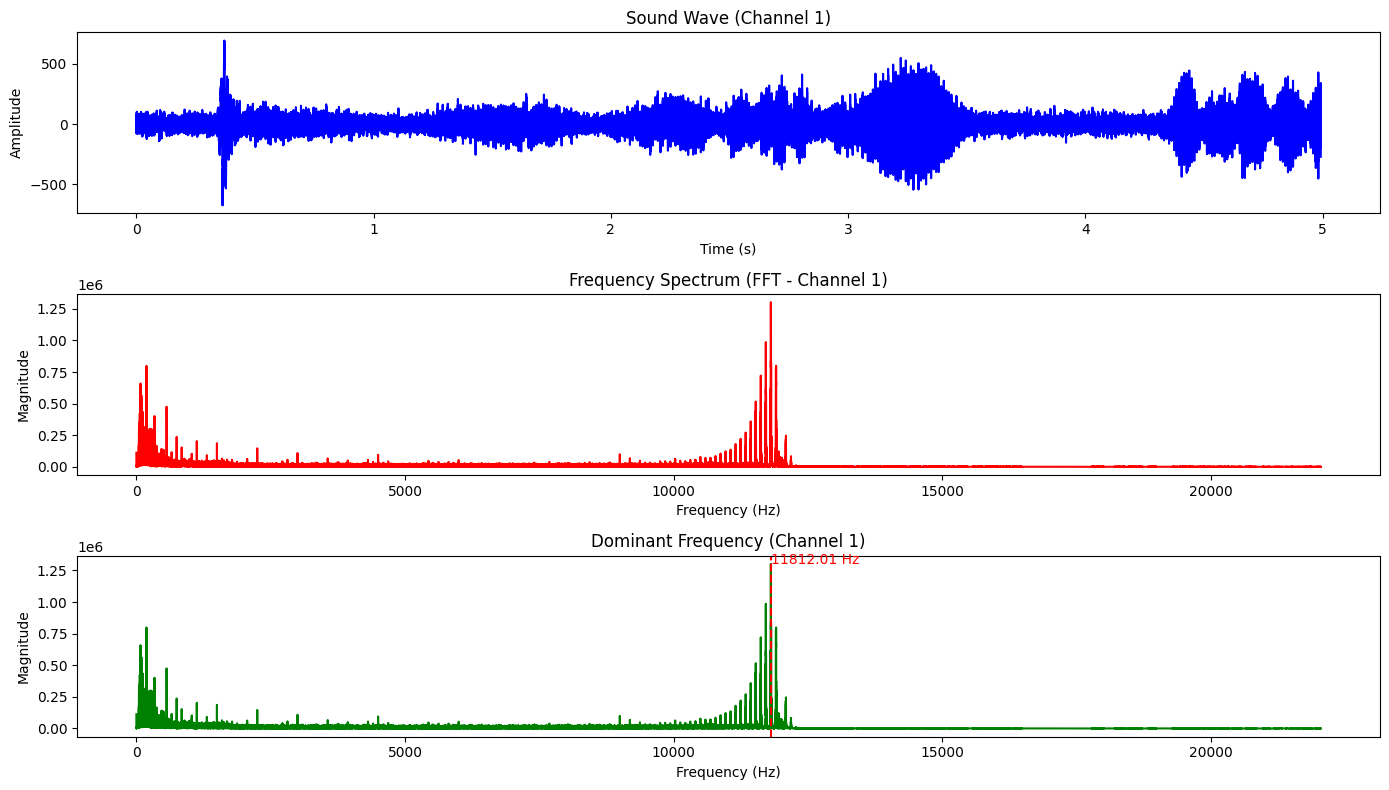

(np.float64(5679.515908136321), np.float64(11812.013535610466))

In [85]:
# play 11900hz max on the devcie of the controller
capture_and_visualize(device_index=1, duration=5)

#### 1.3 Controller mic lower bound

Recording for 20 seconds from device index 1 with 1 channels...
Average Frequency (Channel 1): 3871.58 Hz


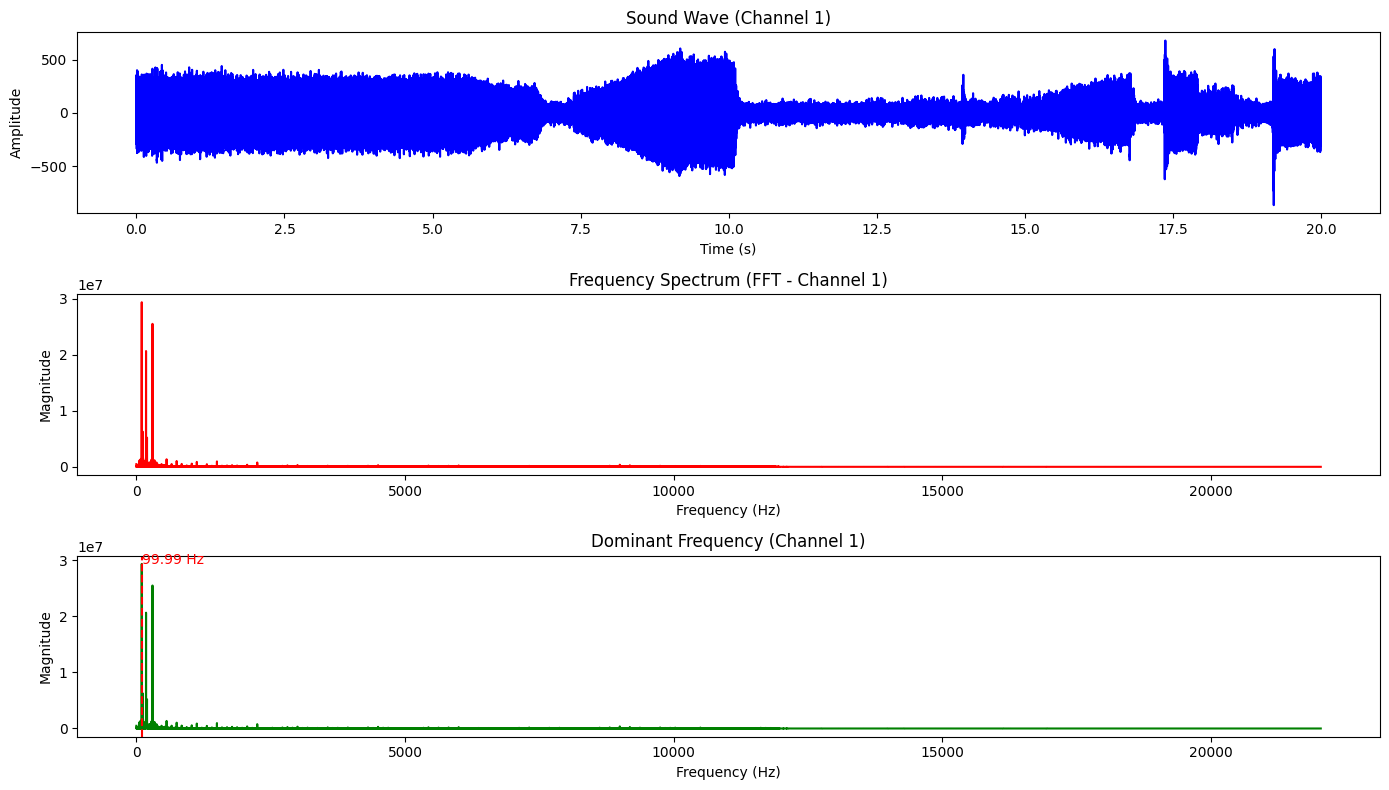

(np.float64(3871.5834807109304), np.float64(99.9880907012195))

In [86]:
# play the sound from 100 to 50 , the minumun of the device is 100hz can be detect 
capture_and_visualize(device_index=1, duration=20)

Result : Frequency limiation of the controlelr 100hz to 11800hz 

## 2 Speaker Limitation

In [3]:
import pyaudio

def list_speakers():
    """
    Lists all available audio output devices with their details.
    Returns a dictionary of output devices with their properties.
    """
    pa = pyaudio.PyAudio()
    output_devices = {}
    
    try:
        default_output = pa.get_default_output_device_info()
        print("\nDefault Output Device:")
        print(f"  Index: {default_output['index']}")
        print(f"  Name: {default_output['name']}")
        print(f"  Channels: {default_output['maxOutputChannels']}")
        print(f"  Sample Rate: {int(default_output['defaultSampleRate'])} Hz")
        print("\nAll Available Output Devices:")
        print("-" * 50)
        
        # Iterate through all audio devices
        for i in range(pa.get_device_count()):
            device_info = pa.get_device_info_by_index(i)
            
            # Check if device has output channels
            if device_info['maxOutputChannels'] > 0:
                output_devices[i] = {
                    'name': device_info['name'],
                    'channels': device_info['maxOutputChannels'],
                    'sample_rate': int(device_info['defaultSampleRate']),
                    'is_default': (i == default_output['index'])
                }
                
                print(f"\nDevice Index: {i}")
                print(f"  Name: {device_info['name']}")
                print(f"  Channels: {device_info['maxOutputChannels']}")
                print(f"  Default Sample Rate: {int(device_info['defaultSampleRate'])} Hz")
                print(f"  Is Default Device: {'Yes' if i == default_output['index'] else 'No'}")
                
                # Show supported sample rates if available
                try:
                    supported_rates = [
                        44100, 48000, 88200, 96000, 192000
                    ]
                    valid_rates = []
                    for rate in supported_rates:
                        try:
                            if pa.is_format_supported(
                                rate,
                                output_device=i,
                                output_channels=device_info['maxOutputChannels'],
                                output_format=pyaudio.paFloat32
                            ):
                                valid_rates.append(rate)
                        except ValueError:
                            continue
                    
                    if valid_rates:
                        print(f"  Supported Sample Rates: {', '.join(map(str, valid_rates))} Hz")
                except Exception as e:
                    print(f"  Could not determine supported sample rates: {e}")
                
                print("-" * 50)
        
        return output_devices
    
    finally:
        pa.terminate()

def get_speaker_info(device_index):
    """
    Get detailed information about a specific output device.
    
    Args:
        device_index (int): The index of the output device
    
    Returns:
        dict: Device information or None if device not found
    """
    pa = pyaudio.PyAudio()
    try:
        device_info = pa.get_device_info_by_index(device_index)
        if device_info['maxOutputChannels'] > 0:
            return {
                'name': device_info['name'],
                'channels': device_info['maxOutputChannels'],
                'sample_rate': int(device_info['defaultSampleRate']),
                'is_default': (device_index == pa.get_default_output_device_info()['index'])
            }
        return None
    except Exception as e:
        print(f"Error getting device info: {e}")
        return None
    finally:
        pa.terminate()

In [4]:
# List all available output devices
speakers = list_speakers()

# Get info about a specific speaker
device_index = 0  # Replace with the index of the speaker you're interested in
speaker_info = get_speaker_info(device_index)
if speaker_info:
    print(f"\nSelected Speaker Details:")
    print(f"Name: {speaker_info['name']}")
    print(f"Channels: {speaker_info['channels']}")
    print(f"Sample Rate: {speaker_info['sample_rate']} Hz")
    print(f"Is Default: {speaker_info['is_default']}")


Default Output Device:
  Index: 0
  Name: DualSense Wireless Controller
  Channels: 4
  Sample Rate: 48000 Hz

All Available Output Devices:
--------------------------------------------------

Device Index: 0
  Name: DualSense Wireless Controller
  Channels: 4
  Default Sample Rate: 48000 Hz
  Is Default Device: Yes
  Supported Sample Rates: 44100, 48000, 88200, 96000, 192000 Hz
--------------------------------------------------

Device Index: 3
  Name: MacBook Air Speakers
  Channels: 2
  Default Sample Rate: 48000 Hz
  Is Default Device: No
  Supported Sample Rates: 44100, 48000, 88200, 96000, 192000 Hz
--------------------------------------------------

Selected Speaker Details:
Name: DualSense Wireless Controller
Channels: 4
Sample Rate: 48000 Hz
Is Default: True


In [13]:
import numpy as np
import pyaudio
import time

import numpy as np
import pyaudio
import time

def play_tone(frequency, duration, device_index=None, volume=1.0, sample_rate=44100, amplitude=1.0):
    """
    Play a sine wave tone with specified frequency and duration on selected device.
    
    Args:
        frequency (float): Frequency of the tone in Hz
        duration (float): Duration of the tone in seconds
        device_index (int): Index of the output device (None for default device)
        volume (float): Volume of the tone (0.0 to 2.0, values > 1.0 will amplify)
        sample_rate (int): Sample rate in Hz
        amplitude (float): Additional amplitude scaling (1.0 to 5.0, use carefully)
    """
    # Initialize PyAudio
    pa = pyaudio.PyAudio()
    
    try:
        # Generate samples for the sine wave
        samples = np.arange(int(duration * sample_rate))
        sine_wave = np.sin(2.0 * np.pi * frequency * samples / sample_rate)
        
        # Apply volume and amplitude scaling
        amplified_wave = sine_wave * volume * amplitude
        
        # Clip the wave to prevent distortion
        amplified_wave = np.clip(amplified_wave, -1.0, 1.0)
        
        # Convert to 32-bit float
        audio_data = amplified_wave.astype(np.float32)
        
        # Open stream with higher buffer size for better performance
        stream = pa.open(
            format=pyaudio.paFloat32,
            channels=1,
            rate=sample_rate,
            output=True,
            output_device_index=device_index,
            frames_per_buffer=2048  # Increased buffer size
        )
        
        try:
            # Play the tone
            print(f"Playing {frequency}Hz tone for {duration} seconds on device index {device_index}")
            print(f"Volume level: {volume}, Amplitude scaling: {amplitude}")
            stream.write(audio_data.tobytes())
            
            # Wait until playback is finished
            time.sleep(duration)
            
        finally:
            stream.stop_stream()
            stream.close()
            
    finally:
        pa.terminate()

def play_sweep(start_freq, end_freq, duration, device_index=None, volume=0.5, sample_rate=44100):
    """
    Play a frequency sweep from start_freq to end_freq.
    
    Args:
        start_freq (float): Starting frequency in Hz
        end_freq (float): Ending frequency in Hz
        duration (float): Duration of the sweep in seconds
        device_index (int): Index of the output device (None for default device)
        volume (float): Volume of the sweep (0.0 to 1.0)
        sample_rate (int): Sample rate in Hz
    """
    pa = pyaudio.PyAudio()
    
    try:
        # Generate time array
        t = np.linspace(0, duration, int(sample_rate * duration))
        
        # Generate logarithmic frequency sweep
        freq = np.exp(np.log(start_freq) + (np.log(end_freq/start_freq) * t/duration))
        phase = 2 * np.pi * freq.cumsum() / sample_rate
        sweep = np.sin(phase)
        
        # Apply volume and convert to 32-bit float
        audio_data = (sweep * volume).astype(np.float32)
        
        # Open stream
        stream = pa.open(
            format=pyaudio.paFloat32,
            channels=1,
            rate=sample_rate,
            output=True,
            output_device_index=device_index,
            frames_per_buffer=1024
        )
        
        try:
            # Play the sweep
            print(f"Playing frequency sweep from {start_freq}Hz to {end_freq}Hz for {duration} seconds")
            stream.write(audio_data.tobytes())
            
            # Wait until playback is finished
            time.sleep(duration)
            
        finally:
            stream.stop_stream()
            stream.close()
            
    finally:
        pa.terminate()

- NOTE:
Due to the driver issue on the macos , the controller should bluetooth connected the mac then wire connect the mac , then it will works as speaker

In [86]:




play_tone(815,3,device_index=0,volume=3,amplitude=1.5)
# based on multi frequency the speak and haptic vibration range is 100 to 800hz 



Playing 815Hz tone for 3 seconds on device index 0
Volume level: 3, Amplitude scaling: 1.5


Based on the experiment and externel detect device , the frequency is 120 to 800hz from the speaker( LRA)

## 3 Play and listen on controller 



play the sound by certain frequency and capture all from and to controller

In [118]:
import numpy as np
import pyaudio
import time
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

def play_and_capture_sound(mic_index=0, speaker_index=None, sound_frequency=440.0, duration=5.0):
    """
    Play a tone at a certain frequency and capture the sound from a microphone.

    Args:
        mic_index (int): Index of the microphone input device.
        speaker_index (int): Index of the speaker output device.
        sound_frequency (float): Frequency of the tone to be played in Hz.
        duration (float): Duration of the tone and recording in seconds.
    """
    # Audio parameters
    sample_rate = 44100
    chunk_size = 1024
    volume = 1.0
    amplitude = 1.0
    channels = 1
    
    # Initialize PyAudio
    pa = pyaudio.PyAudio()

    try:
        # Generate the sine wave tone
        samples = np.arange(int(duration * sample_rate))
        sine_wave = np.sin(2.0 * np.pi * sound_frequency * samples / sample_rate)
        amplified_wave = sine_wave * volume * amplitude
        amplified_wave = np.clip(amplified_wave, -1.0, 1.0)
        audio_data = (amplified_wave.astype(np.float32)).tobytes()

        # Open speaker stream
        speaker_stream = pa.open(
            format=pyaudio.paFloat32,
            channels=1,
            rate=sample_rate,
            output=True,
            output_device_index=speaker_index,
            frames_per_buffer=chunk_size
        )

        # Open microphone stream
        mic_stream = pa.open(
            format=pyaudio.paInt16,
            channels=channels,
            rate=sample_rate,
            input=True,
            input_device_index=mic_index,
            frames_per_buffer=chunk_size
        )

        print(f"Playing {sound_frequency} Hz tone and recording simultaneously...")

        # Play and record simultaneously
        frames = []
        for _ in range(0, int(sample_rate / chunk_size * duration)):
            speaker_stream.write(audio_data[:chunk_size * 4])
            mic_data = mic_stream.read(chunk_size)
            frames.append(np.frombuffer(mic_data, dtype=np.int16))

        # Close streams
        speaker_stream.stop_stream()
        speaker_stream.close()
        mic_stream.stop_stream()
        mic_stream.close()

        # Combine frames into a single numpy array
        audio_data = np.concatenate(frames)

        # Reshape for multi-channel (if applicable)
        if channels > 1:
            audio_data = audio_data.reshape(-1, channels)
            audio_data = audio_data[:, 0]  # Analyze the first channel

        # Time domain visualization
        plt.figure(figsize=(14, 6))
        plt.subplot(2, 1, 1)
        time_axis = np.linspace(0, len(audio_data) / sample_rate, num=len(audio_data))
        plt.plot(time_axis, audio_data, color='blue')
        plt.title("Sound Wave")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        # Frequency domain visualization
        fft_data = fft(audio_data)
        fft_magnitude = np.abs(fft_data)[:len(fft_data) // 2]
        freqs = fftfreq(len(audio_data), 1 / sample_rate)[:len(fft_data) // 2]

        # Find two largest peaks in the FFT magnitude
        sorted_indices = np.argsort(fft_magnitude)[::-1]  # Sort indices of peaks in descending order
        peak1_idx = sorted_indices[0]  # Largest peak
        peak2_idx = sorted_indices[1]  # Second largest peak

        peak1_freq = freqs[peak1_idx]
        peak2_freq = freqs[peak2_idx]
        peak1_mag = fft_magnitude[peak1_idx]
        peak2_mag = fft_magnitude[peak2_idx]

        # Plot FFT with the two dominant peaks highlighted
        plt.subplot(2, 1, 2)
        plt.plot(freqs, fft_magnitude, color='green')
        plt.title("Dominant Frequencies")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.text(peak1_freq, peak1_mag, f'{peak1_freq:.2f} Hz', color='red')
        plt.text(peak2_freq, peak2_mag, f'{peak2_freq:.2f} Hz', color='blue')

        plt.tight_layout()
        plt.show()

        print(f"Dominant Frequencies: {peak1_freq:.2f} Hz and {peak2_freq:.2f} Hz")

    finally:
        pa.terminate()


Playing 120 Hz tone and recording simultaneously...


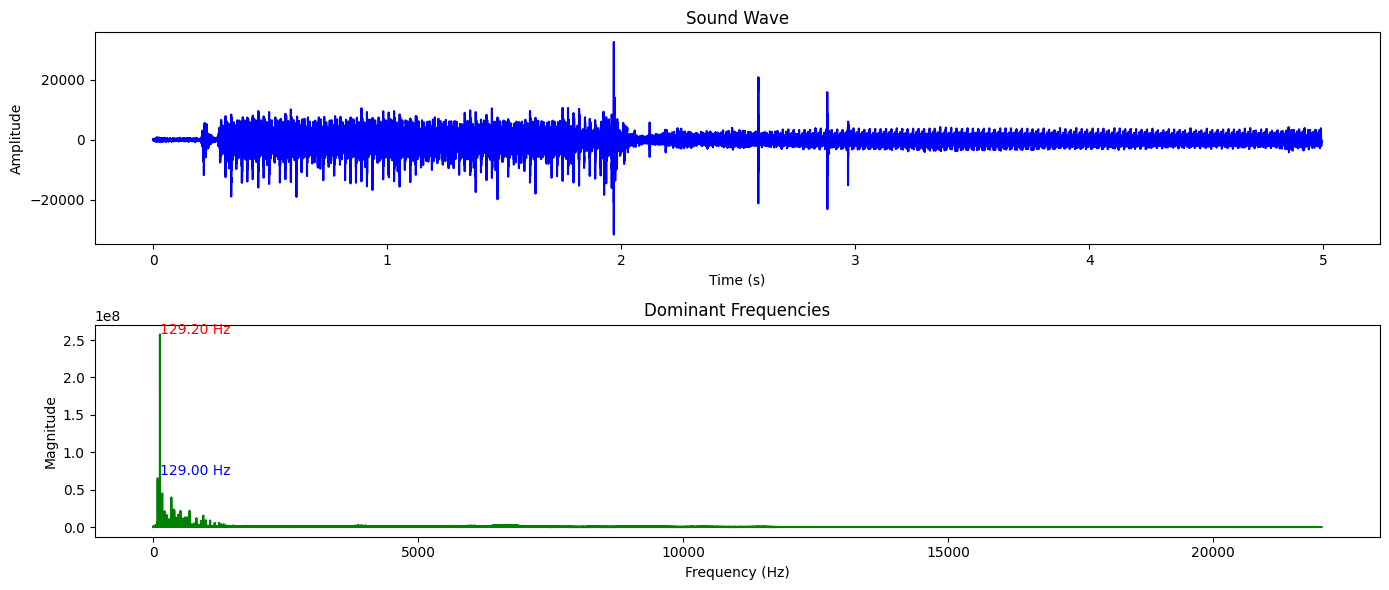

Dominant Frequencies: 129.20 Hz and 129.00 Hz


In [134]:

speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=120, duration=5.0)



Playing 900 Hz tone and recording simultaneously...


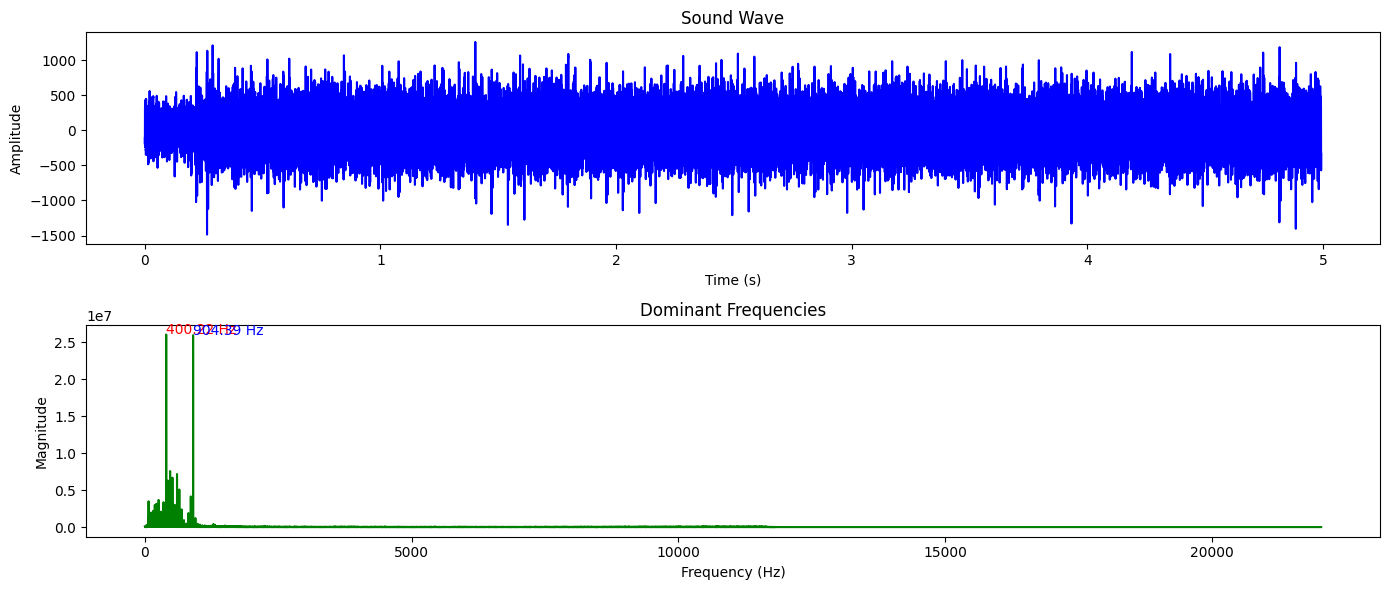

Dominant Frequencies: 400.22 Hz and 904.39 Hz


In [140]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=900, duration=5.0)

Playing 800 Hz tone and recording simultaneously...


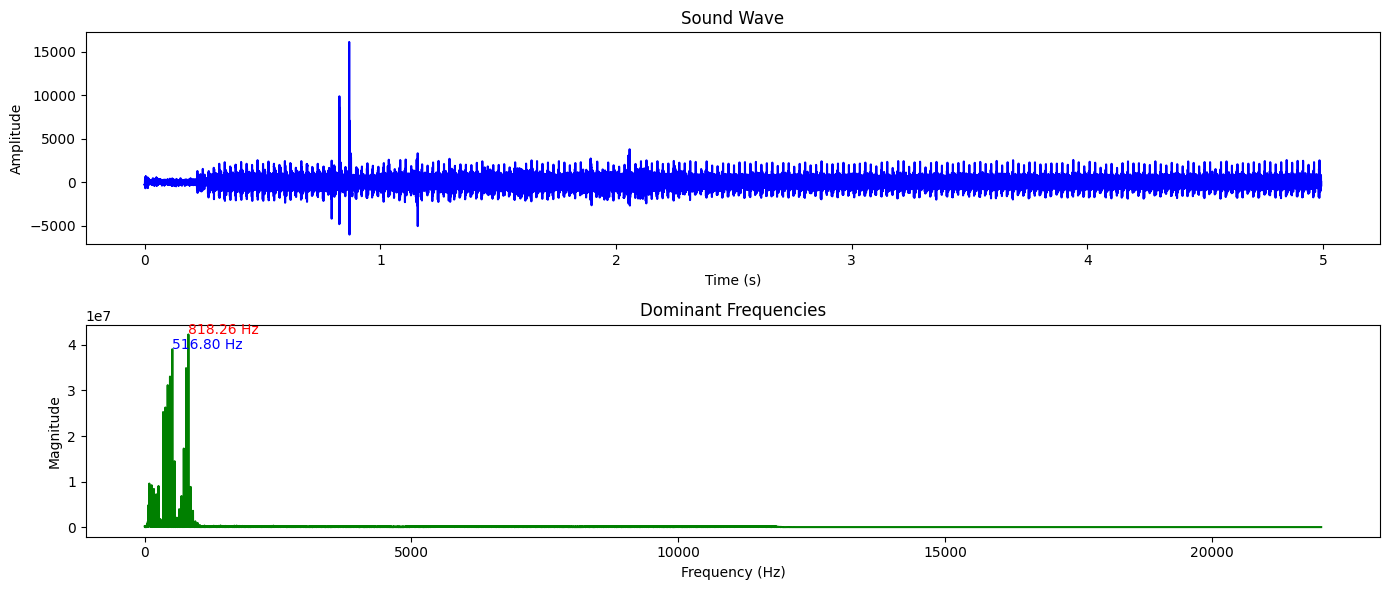

Dominant Frequencies: 818.26 Hz and 516.80 Hz


In [124]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=800, duration=5.0)

Playing 700 Hz tone and recording simultaneously...


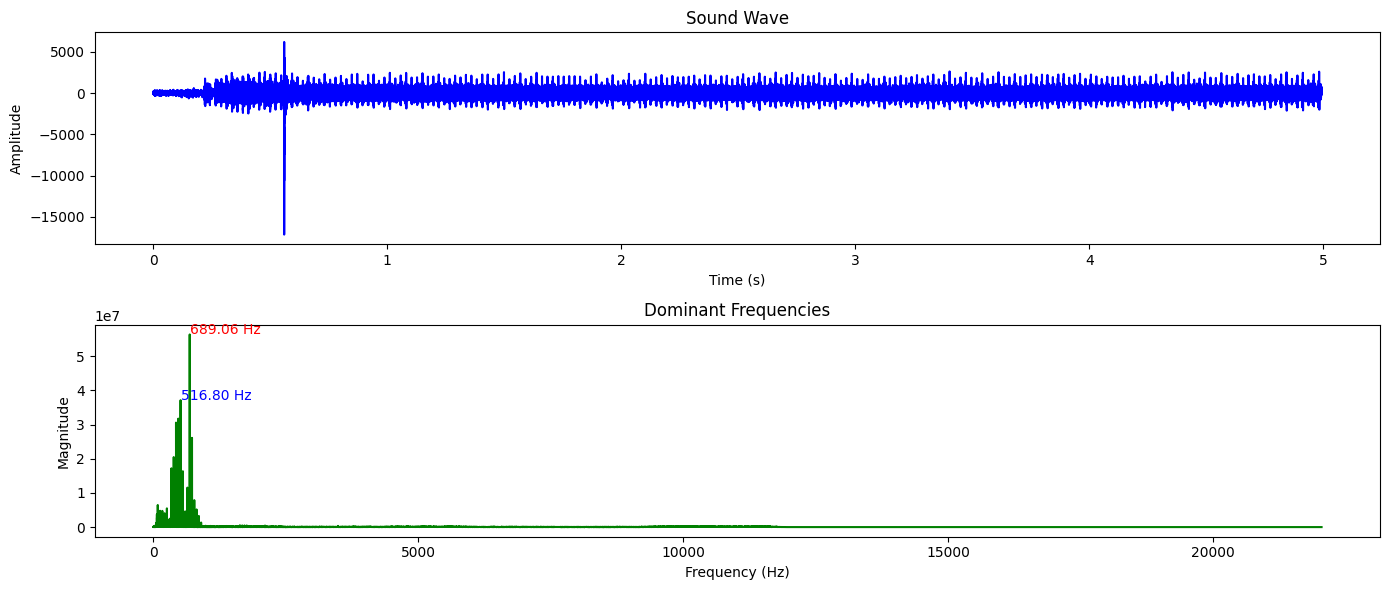

Dominant Frequencies: 689.06 Hz and 516.80 Hz


In [125]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=700, duration=5.0)

Playing 600 Hz tone and recording simultaneously...


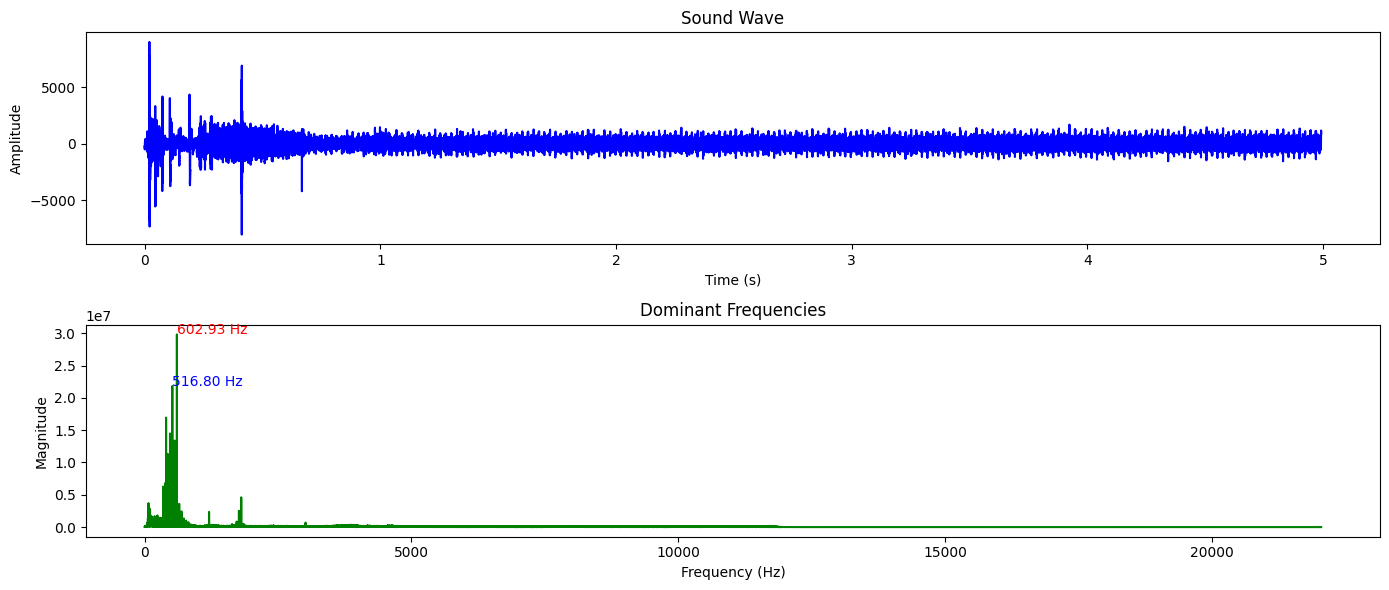

Dominant Frequencies: 602.93 Hz and 516.80 Hz


In [126]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=600, duration=5.0)

Playing 400 Hz tone and recording simultaneously...


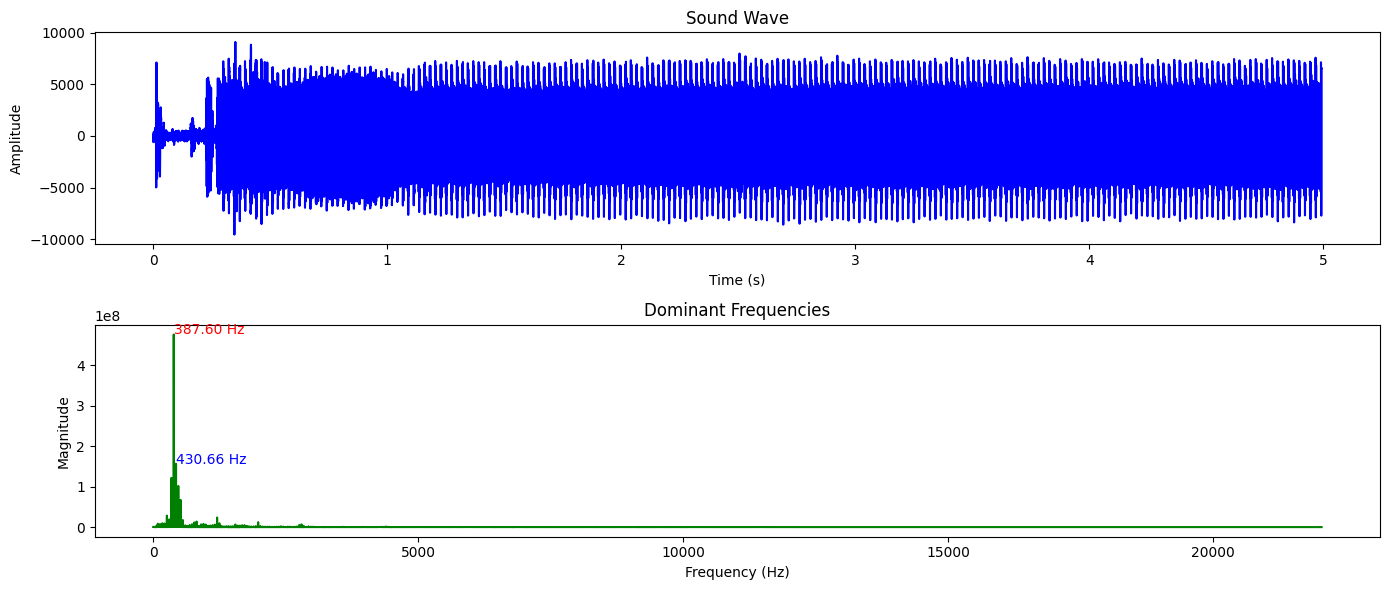

Dominant Frequencies: 387.60 Hz and 430.66 Hz


In [127]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=400, duration=5.0)

Playing 300 Hz tone and recording simultaneously...


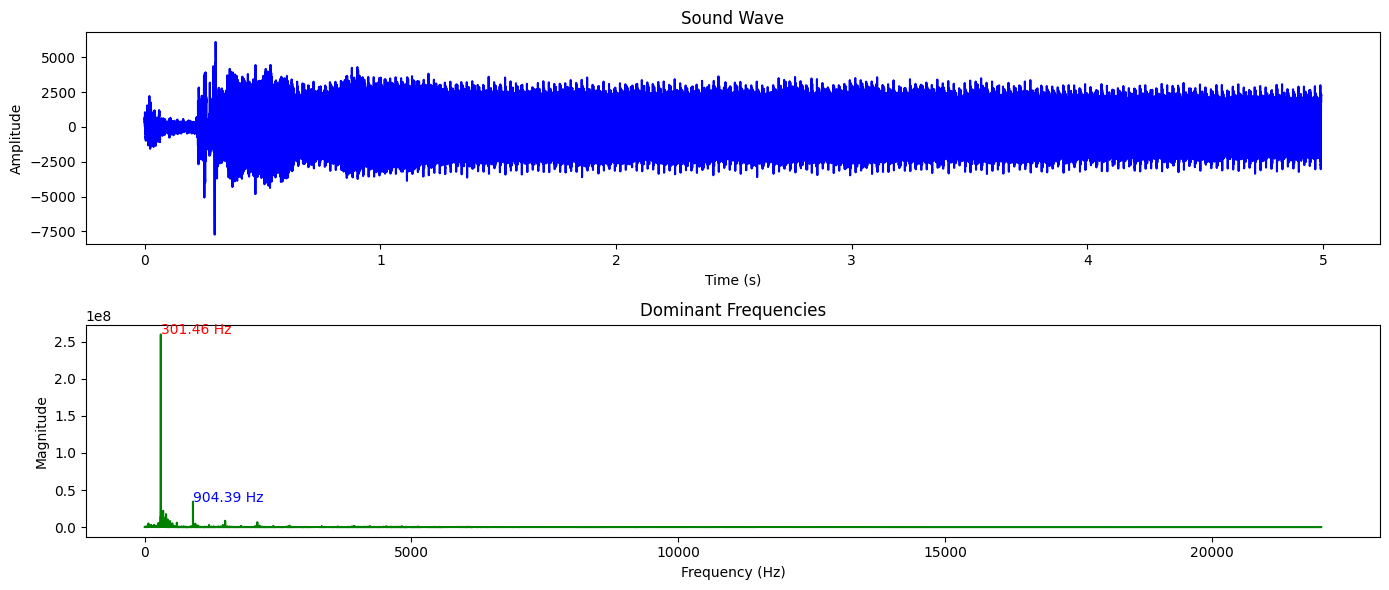

Dominant Frequencies: 301.46 Hz and 904.39 Hz


In [128]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=300, duration=5.0)

Playing 80 Hz tone and recording simultaneously...


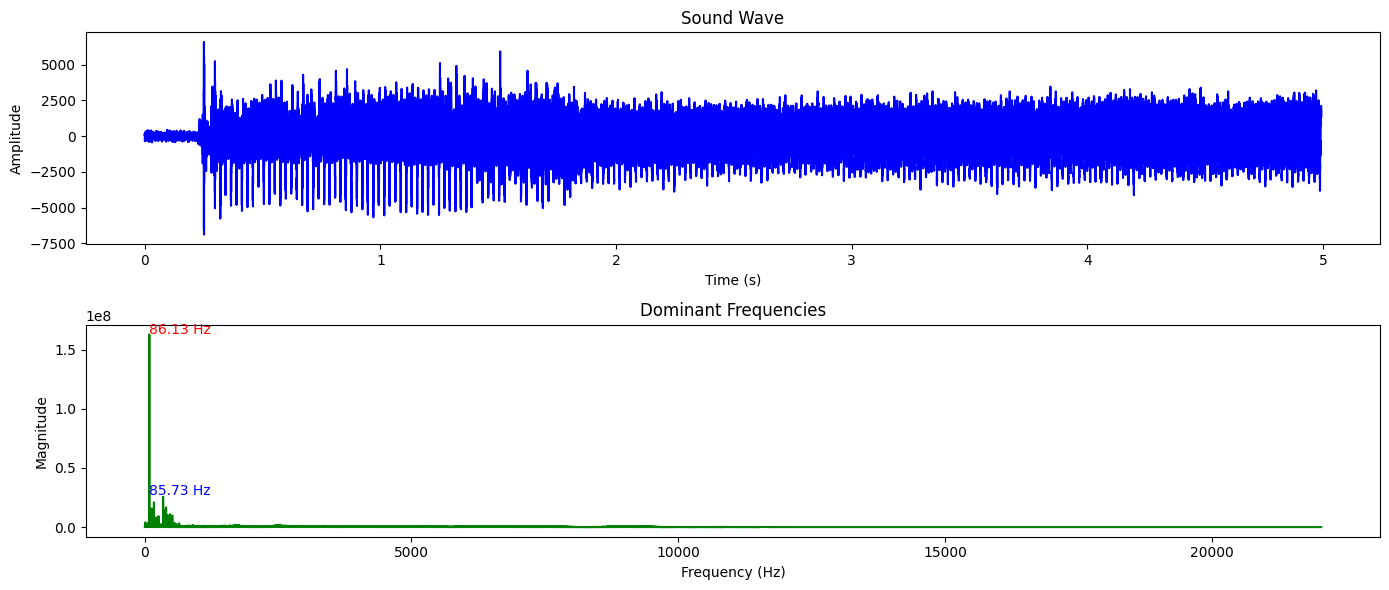

Dominant Frequencies: 86.13 Hz and 85.73 Hz


In [129]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=80, duration=5.0)

Playing 120 Hz tone and recording simultaneously...


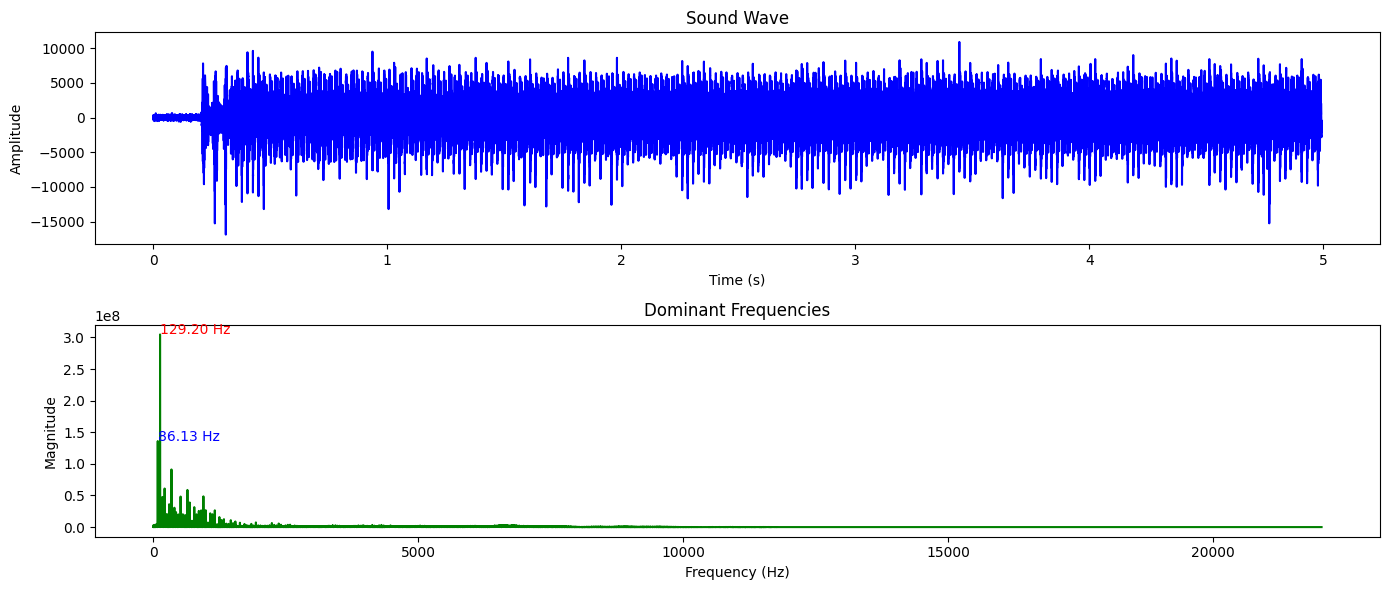

Dominant Frequencies: 129.20 Hz and 86.13 Hz


In [139]:
speaker_index,mic_index=0,1

play_and_capture_sound(mic_index=mic_index, speaker_index=speaker_index, sound_frequency=120, duration=5.0)

## 4 Conclusion


Conclusion:

- Harmonics and Aliasing Interactions: When playing a tone at frequencies like 900Hz or 800Hz, two prominent peaks are detected in the frequency spectrum—one around 400Hz or 450Hz, and the other at the played frequency. This phenomenon is due to harmonics and aliasing interactions.

- Low Frequency Detection: Frequencies below 120Hz are not detectable by the system. The Linear Resonant Actuator (LRA) exhibits more noticeable vibration at these lower frequencies compared to higher frequencies.

- Effective Sound Frequency Range: The effective sound frequency range for the internal microphone is between 120Hz and 900Hz. Within this range, some frequencies may show additional harmonic or aliasing effects.

- Frequency range of the controlelr's mic 100hz to 11800hz 